In [3]:
# # https://pypi.org/project/quickdraw
# from quickdraw import QuickDrawData
import numpy as np
import urllib.request
import os
import glob as gb
import pathlib
import random
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import torch.nn as nn
from torch import optim
from torchsummary import summary
from torch.utils.data import DataLoader

# import custom data / utils
from data import *
from utils import *
from models.model import *
from train import *

In [7]:
set_seed(1)

## Prepare Dataset

In [12]:
load_dataset()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bear.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bicycle.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bus.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cup.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/duck.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fish.npy
ht

## Check Device & Hyperparameter

In [13]:
DEVICE = check_device()

Using Pytorch version :  1.12.1 DEVICE :  cuda


In [14]:
# hyperparameter
BATCH_SIZE = 128
EPOCHS = 20
LEARING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

## Load Data

In [15]:
dataset, train_dataset, val_dataset, test_dataset, classes = prepare_dataset()

Means: tensor([0.1702])
STDs: tensor([0.3224])


In [11]:
# remove npy files
def remove_dataset(npy_files_path='./dataset/*.npy'):
    npy_files = gb.glob(npy_files_path)
    for npy_file in npy_files:
        os.remove(npy_file)
        
    print('remove files')
    
remove_dataset()

remove files


In [16]:
# tensor index to class label
def idx_to_class(y_idx):
  return classes[int(y_idx.item())]

In [14]:
count_dict = {c : 0 for c in classes}

for _, labels in train_dataset:
  label = idx_to_class(labels)
  count_dict[label] += 1
  
print(count_dict)

{'airplane': 8000, 'apple': 8000, 'banana': 8000, 'baseball': 8000, 'bear': 8000, 'bicycle': 8000, 'bird': 8000, 'bus': 8000, 'cat': 8000, 'cup': 8000, 'dog': 8000, 'duck': 8000, 'fish': 8000, 'flower': 8000, 'hamburger': 8000, 'house': 8000, 'ice_cream': 8000, 'light_bulb': 8000, 'lion': 8000, 'monkey': 8000, 'moon': 8000, 'nose': 8000, 'pencil': 8000, 'pig': 8000, 'rabbit': 8000, 'shoe': 8000, 'spider': 8000, 'sun': 8000, 'tree': 8000, 'umbrella': 8000}


save figure:  train_dataet_distribution


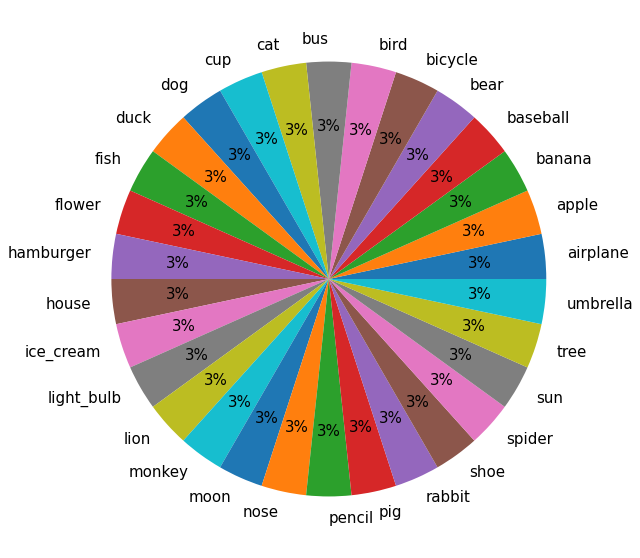

In [15]:
classes = list(count_dict.keys())
count = list(count_dict.values())

#https://ehclub.net/677
plt.figure(figsize=(10, 10))
textprops = dict(size=15, weight=3,)
plt.pie(count, labels=classes, autopct='%.f%%', pctdistance=0.7, textprops=textprops);

save_figure('train_dataset_distribution')

In [17]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
for (X_train, y_train) in train_loader:
  print(f'Shape of X_train [N, C, H, W] : {X_train.shape}', f'\nType of X_train : {X_train.dtype}\n')  # X_train.type() : torch.FloatTensor
  print(f'Shape of y_train [N, C, H, W] : {y_train.shape}', f'\nType of y_train : {y_train.dtype}\n')  # y_traon.type() : torch.LongTensor
  break

Shape of X_train [N, C, H, W] : torch.Size([128, 1, 28, 28]) 
Type of X_train : torch.float32

Shape of y_train [N, C, H, W] : torch.Size([128]) 
Type of y_train : torch.float32



## Data Visualization

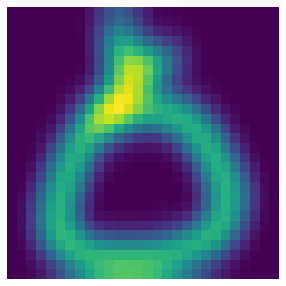

In [19]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

imshow(images[0], idx_to_class(labels[0]))
save_figure(label)

save figure:  10_quickdraw_visualization


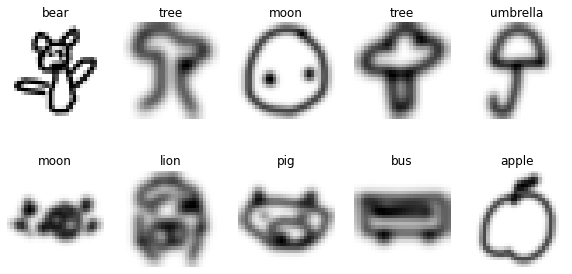

In [20]:
plt.figure(figsize=(10, 5))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].squeeze(), cmap='binary')  # X_train [32, 1, 28, 28] -> [i, :, :, :] -> squeeze() -> [28, 28]
  plt.title(idx_to_class(y_train[i]))
  
save_figure('10_quickdraw_visualization')

## Model

In [21]:
model = resnet34(pretrained=True)

c:\ProgramData\Miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
model = model.to(DEVICE)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             576
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,864
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          36,864
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
       BasicBlock-11           [-1, 64, 14, 14]               0
           Conv2d-12           [-1, 64, 14, 14]          36,864
      BatchNorm2d-13           [-1, 64, 14, 14]             128
             ReLU-14           [-1, 64,

In [23]:
optimizer = optim.AdamW(model.parameters(), lr=LEARING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)

criterion = nn.CrossEntropyLoss()

## Train

In [24]:
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

In [25]:
#check best validation loss
best_val_loss = float('inf')

training_start_time = training_start_time = time.time()

for epoch in range(EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, criterion, optimizer,DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    scheduler.step()
    
    #Saving model whenver the best validation loss is obtained
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './models/checkpoint/model.pt')
    
    #check time
    end_time = time.time()
    epoch_mins, epoch_secs,  = epoch_time(start_time, end_time) 
    
  
    print(f'\nEpoch: {epoch+1:02}/{EPOCHS} Time: {epoch_mins}m {epoch_secs}s')
    print('========================= Train =========================')
    print(f'Train Loss: {train_loss:.3f} Train Accuracy: {train_acc*100:.3f}%')
    print('======================= Validation ======================')
    print(f'Validation Loss: {val_loss:.3f} Validation Accuracy: {val_acc*100:.3f}%')

total_trainig_time = time.time() - training_start_time
print(f'\nDone! Total Training Time: {total_trainig_time//60:.0f}m {total_trainig_time%60:.0f}s')
print(f'Best Validation Loss: {best_val_loss:3f}')


Epoch: 01/20 Time: 7m 45s
========================= Train =========================
Train Loss: 0.820 Train Accuracy: 76.479%
======================= Validation ======================
Validation Loss: 0.548 Validation Accuracy: 83.706%

Epoch: 02/20 Time: 7m 51s
========================= Train =========================
Train Loss: 0.512 Train Accuracy: 84.616%
======================= Validation ======================
Validation Loss: 0.452 Validation Accuracy: 86.513%

Epoch: 03/20 Time: 7m 53s
========================= Train =========================
Train Loss: 0.432 Train Accuracy: 86.894%
======================= Validation ======================
Validation Loss: 0.428 Validation Accuracy: 87.370%

Epoch: 04/20 Time: 7m 59s
========================= Train =========================
Train Loss: 0.377 Train Accuracy: 88.357%
======================= Validation ======================
Validation Loss: 0.412 Validation Accuracy: 87.991%

Epoch: 05/20 Time: 7m 51s
=========================

KeyboardInterrupt: 

save figure:  resnet34_loss_acc


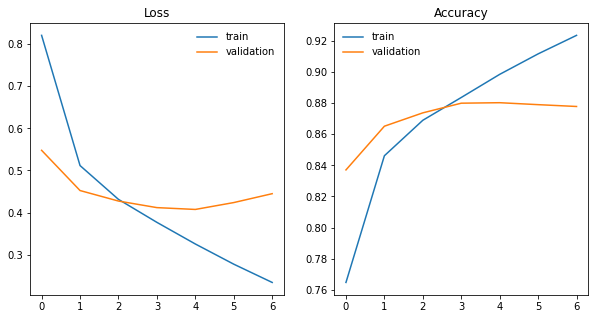

In [32]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.title('Loss')
plt.legend(frameon=False)


plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='validation')
plt.title('Accuracy')
plt.legend(frameon=False)
save_figure('resnet34_loss_acc')

plt.show()

## Inference

In [33]:
model_ = resnet34(pretrained=True)
model_.load_state_dict(torch.load('./models/checkpoint/resnet34.pt'))
model_ = model_.to(DEVICE)

c:\ProgramData\Miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loss, test_acc = evaluate(model_, test_loader, criterion, DEVICE)

print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8767


predict : cup
truth : cup


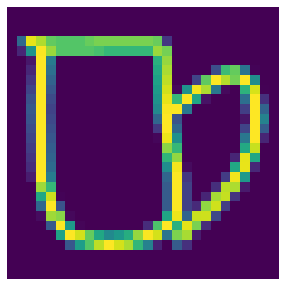

In [35]:
test_img_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

model_.eval()
img, label = next(iter(test_img_loader))
y_pred=idx_to_class(torch.argmax(model_(img.to(DEVICE)), 1))
y_truth=idx_to_class(label[0])

print(f"predict : {y_pred}\ntruth : {y_truth}")
imshow(img[0], y_truth)

save figure:  test_accuracy_confusion_matrix_resnet34


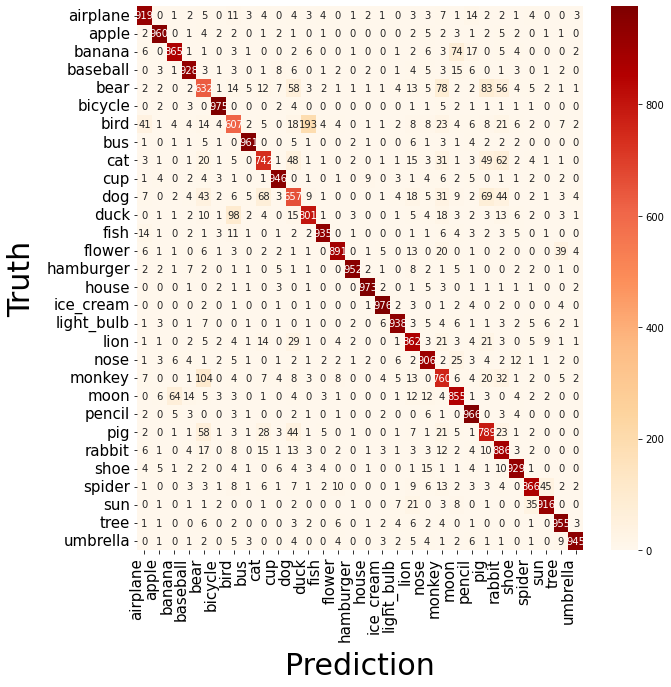

In [38]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


num_classes = len(classes)
confusion_matrix = np.zeros((num_classes, num_classes))

model_.eval()
with torch.no_grad():
    for (X, y) in test_loader:
        X = X.type(torch.float32).to(DEVICE)
        y = y.type(torch.LongTensor).to(DEVICE)
        y_pred = model_(X).argmax(dim=1, keepdim = True)
        y_truth = y
        for truth, pred in zip(y.view(-1), y_pred.view(-1)):
            confusion_matrix[truth.long(), pred.long()] += 1
            

plt.figure(figsize=(10, 10))
df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='OrRd')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right',fontsize=15)
plt.ylabel('Truth', fontsize = 30, labelpad=10)
plt.xlabel('Prediction', fontsize = 30, labelpad=10)
save_figure('test_accuracy_confusion_matrix_resnet34')

In [39]:
print(np.diag(confusion_matrix) / confusion_matrix.sum(1))

[0.919 0.96  0.865 0.928 0.632 0.975 0.607 0.961 0.742 0.946 0.657 0.801
 0.935 0.891 0.952 0.973 0.976 0.938 0.862 0.906 0.76  0.855 0.966 0.789
 0.886 0.929 0.866 0.916 0.955 0.945]
